<a href="https://colab.research.google.com/github/ayush-96/msc-data-science/blob/master/information_retrieval/Information_Retrieval_(H_M)_2025_Lab_1_TEMPLATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 - PyTerrier introduction

In this notebook, we provide an introduction to [PyTerrier](https://github.com/terrier-org/pyterrier). This lab is an unassessed exercise, as preparation for the main exercises.

The intended learning outcome of this lab is to provide an introduction to PyTerrier as well as an illustration of some fundamental concepts in IR (this will be followed by a PyTerrier tutorial in the class).
  - installation
  - indexing a collection
  - accessing an index
  - the TerrierRetriever transformer for searching an index
  - reformulating queries
  - composing transformers together to make retrieval pipelines

Pre-requisites:
 - We assume that you are confident in programming Python, including [lambda functions](https://realpython.com/python-lambda/).
 - We assume that you have completed the pre-sessional notebook, which includes a Pandas refresher.
 - We will **only be supporting notebooks on the Google Colab platform**.
 - You can also try to use your own personal machine, but if you have problems, you should resort to using Colab.

Related Reading:
 - [Pandas documentation](https://pandas.pydata.org/docs/)
 - [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/)

Efforts Required:
 - We don't expect everyone to complete this lab within their allotted lab hour. You will need to spend some time on it outside of the lab. Exercise 1 (assessed), builds on the learning outcomes of this lab, so it's essential you complete this Lab before starting on Exercise 1. We recommend that you complete this Lab before 1st February 2025.



In the following, we aim to illustrate concepts we will be studying in the early lectures of the course.

PyTerrier is a Python framework, but uses the underlying [Terrier.org information retrieval toolkit](http://terrier.org) for many indexing and retrieval operations. While PyTerrier is a recent framework (launched in 2020), Terrier is written in Java and has a long history dating back to 2001. PyTerrier makes it easy to perform modern IR experiments in Python, but uses the mature Terrier platform for the expensive indexing and retrieval operations.

In the following, we introduce everything you need to know about PyTerrier (which we will build on in the PyTerrier tutorial and both Ex1 & Ex2), and also provide appropriate links to relevant parts of the [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/).


### Installation & Configuration

PyTerrier is installed as follows. This might take a few minutes, so you can read on.

In [2]:
%pip install -q python-terrier
import pyterrier as pt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.8 MB/s eta 0:00:00


### Documents, Indexing and Indexes

Much of PyTerrier's view of the world is wrapped up in Pandas dataframes. Let's consider some textual documents in a dataframe.


In [24]:
import pandas as pd
docs_df = pd.DataFrame([
    ["d1", "this is the first document of many documents"],
    ["d2", "this is another document"],
    ["d3", "the topic of this document is unknown"],
    ["d4", "this is another document to test things with and automobile term"],
    ["d5", "another distinguishable tokenization document about glasgow 1945"]
], columns=["docno", "text"])
docs_df

,docno,text
0,d1,this is the first document of many documents
1,d2,this is another document
2,d3,the topic of this document is unknown
3,d4,this is another document to test things with a...
4,d5,another distinguishable tokenization document ...


Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents. The index is written into a directory called `index_3docs`.

In [25]:
indexer = pt.IterDictIndexer("./index_3docs", overwrite=True)
indexref = indexer.index(docs_df.to_dict(orient="records"))
indexref.toString()

'./index_3docs/data.properties'

An IndexRef is essentially a string saying where an index is stored.

Indeed, we can look in the `index_3docs` directory and see that it has created various small files. The filenames give hints to the corresponding data structures:
 - some files relating to a lexicon (aka vocabulary)
 - a file relating to the inverted index
 - a file relating to the direct index (aka forward index, used for QE)
 - files relating to document metadata (e.g. storing the unique identifiers for documents) and document lengths


In [26]:
!ls -lh index_3docs/

total 44K
-rw-r--r-- 1 root root    7 Feb  7 14:46 data.direct.bf
-rw-r--r-- 1 root root   85 Feb  7 14:46 data.document.fsarrayfile
-rw-r--r-- 1 root root    9 Feb  7 14:46 data.inverted.bf
-rw-r--r-- 1 root root  946 Feb  7 14:46 data.lexicon.fsomapfile
-rw-r--r-- 1 root root  321 Feb  7 14:46 data.lexicon.fsomaphash
-rw-r--r-- 1 root root   44 Feb  7 14:46 data.lexicon.fsomapid
-rw-r--r-- 1 root root  325 Feb  7 14:46 data.meta-0.fsomapfile
-rw-r--r-- 1 root root   40 Feb  7 14:46 data.meta.idx
-rw-r--r-- 1 root root   90 Feb  7 14:46 data.meta.zdata
-rw-r--r-- 1 root root 4.1K Feb  7 14:46 data.properties


How can we make an IndexRef useful - we can load it to an actual index - `pt.IndexFactory.of()` is the relevant factory.

In [27]:
index = pt.IndexFactory.of(indexref)

#lets see what Python type index is.
type(index)

jnius.reflect.org.terrier.structures.Index

Ok, so this object refers to Terrier's [Index type](http://terrier.org/docs/current/javadoc/org/terrier/structures/Index.html). Check the linked Javadoc - you will see that this Java object has methods such as:
 - getCollectionStatistics()
 - getInvertedIndex()
 - getLexicon()

Let's see what's in the [CollectionStatistics](http://terrier.org/docs/current/javadoc/org/terrier/structures/CollectionStatistics.html):

In [28]:
print(index.getCollectionStatistics())

Number of documents: 5
Number of terms: 11
Number of postings: 15
Number of fields: 0
Number of tokens: 16
Field names: []
Positions:   false



Ok, that seems fair - we have 3 documents. But why only 4 terms?
Let's check the [Lexicon](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html), which is our vocabulary. Fortunately, the Lexicon can be iterated easily from Python:

In [29]:
for k, v in index.getLexicon():
  print("%s (%s) -> %s (%s)" % (k, type(k), v, type(v) ) )

1945 (<class 'str'>) -> term7 Nt=1 TF=1 maxTF=1 @{0 0 0} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
automobil (<class 'str'>) -> term4 Nt=1 TF=1 maxTF=1 @{0 0 6} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
distinguish (<class 'str'>) -> term9 Nt=1 TF=1 maxTF=1 @{0 1 4} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
document (<class 'str'>) -> term0 Nt=5 TF=6 maxTF=2 @{0 2 2} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
first (<class 'str'>) -> term1 Nt=1 TF=1 maxTF=1 @{0 3 5} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
glasgow (<class 'str'>) -> term8 Nt=1 TF=1 maxTF=1 @{0 3 7} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
term (<class 'str'>) -> term6 Nt=1 TF=1 maxTF=1 @{0 4 5} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
test (<class 'str'>) -> term5 Nt=1 TF=1 maxTF=1 @{0 5 3} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
token (<class 'str'>) -> ter

Here, iterating over the Lexicon returns a tuple of a String term, and a [LexiconEntry](http://terrier.org/docs/current/javadoc/org/terrier/structures/LexiconEntry.html) -- which itself is an [EntryStatistics](http://terrier.org/docs/current/javadoc/org/terrier/structures/EntryStatistics.html) -- and contains information including the statistics of that term.


So what did we find? Here are some observations:
 - we only have 4 unique terms, as stopwords were removed
 - we have one term for `"document"`, even though `"documents"` occurred in document "d1".

Both these observations make sense. Indeed, by default, Terrier removes standard stopwords and applies Porter's stemmer.

Further:
 - `Nt` is the number of unique documents that each term occurs in. This is useful for calculating IDF (c.f. Lecture 3)
 - `TF` is the total number of occurrences - some weighting models use this instead of Nt.
 - The numbers in the `@{}` are a pointer - they tell Terrier where the postings are for that term in the inverted index data structure.

Finally, we can also use the square bracket notation to lookup terms in Terrier's lexicon. This is equivalent to [Lexicon.getLexiconEntry("chemical")](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html#getLexiconEntry(KEY))


In [30]:
index.getLexicon()["document"].toString()

'term0 Nt=5 TF=6 maxTF=2 @{0 2 2}'

Let's now think about the inverted index. Remember from Lecture 2 that the inverted index tells us in which *documents* each term occurs in. The LexiconEntry is the pointer that tells us where to find the postings for that term in the inverted index.

In [31]:
pointer = index.getLexicon()["document"]
for posting in index.getInvertedIndex().getPostings(pointer):
  print(posting.toString() + " doclen=%d" % posting.getDocumentLength())

ID(0) TF(2) doclen=3
ID(1) TF(1) doclen=1
ID(2) TF(1) doclen=3
ID(3) TF(1) doclen=4
ID(4) TF(1) doclen=5


Ok, so we can see that `"document"` occurs once in each of the three documents. NB: Terrier counts documents as integers from 0 (called *docids*). It records the mapping back to *docnos* (the string form, i.e. "d1", "d2") in a separate data structure called the MetaIndex.

Similarly, we can see what terms occur in document d1, by using a datastructure called the *direct* index. You can think of this as the opposite of the inverted index: the inverted index tells us, for each term, which documents contain that term; the direct index tells us, for each document, which terms it contains.

Let's define a function to show us the contents of a document using the direct index. This a translation of [the Java code for displaying the contents of a document in the Terrier documentation](https://github.com/terrier-org/terrier-core/blob/5.x/doc/extend_retrieval.md#what-terms-occur-in-the-11th-document). When using our function, we can specify which document either by docno (string) or docid (int).

In [32]:
def get_document_direct(index, docno=None, docid=None):
  if docid is None and docno is None:
    raise ValueError("Must specify docno or docid")
  if docno is not None:
    docid = index.getMetaIndex().getDocument("docno", docno)
  else:
    docno = index.getMetaIndex().getItem("docno", docid)

  rtr = "Docno %s (docid %d)\n" % (docno, docid)
  pointer = index.getDocumentIndex().getDocumentEntry(docid)
  for p in index.getDirectIndex().getPostings(pointer):
    termid = p.getId()
    term = index.getLexicon()[termid].getKey()
    rtr += ("\t%s %d\n" % ( term, p.getFrequency()))
  return rtr

In [33]:
print(get_document_direct(index, docno="d1"))

Docno d1 (docid 0)
	document 2
	first 1



In [34]:
print(get_document_direct(index, docid=0))

Docno d1 (docid 0)
	document 2
	first 1



### Searching an Index

Our way into search in PyTerrier is called terrier.Retriever. terrier.Retriever is configured by specifying an index and a weighting model. We then search for a single-word query, `"document"`.

In [40]:
br = pt.terrier.Retriever(index, wmodel="Tf")
print(br.search("document"))

tf_idf = pt.terrier.Retriever(index, wmodel="TF_IDF")
bm25 = pt.terrier.Retriever(index, wmodel="BM25")
pl2 = pt.terrier.Retriever(index, wmodel="PL2")

print(tf_idf.search("glasgow"))
print(bm25.search("automobile"))
print(pl2.search("first"))

  qid  docid docno  rank  score     query
0   1      0    d1     0    2.0  document
1   1      1    d2     1    1.0  document
2   1      2    d3     2    1.0  document
3   1      3    d4     3    1.0  document
4   1      4    d5     4    1.0  document
  qid  docid docno  rank     score    query
0   1      4    d5     0  1.146219  glasgow
  qid  docid docno  rank     score       query
0   1      3    d4     0  1.437904  automobile
  qid  docid docno  rank     score  query
0   1      0    d1     0  1.288665  first


So `search()` returns a dataframe with columns:
 - qid: this is by default "1", since it's our first and only query
 - docid: Terrier' internal integer for each doucment
 - docno: the external (string) unique identifier for each document
 - score: the total frequency of the query (terms) in each document
 - rank: A handy attribute showing the descending order by score
 - query: the input query

As expected, the Tf weighting model used here only counts the frequencies of the query terms in each document, i.e.:
$$
score(d,Q) = \sum_{t \in Q} tf_{t,d}
$$

Hence, it's clear that document d1 should be the highest scored document with two occurrences (c.f. `'document'` and `'documents'`) since we are using stemming.

We can also pass a dataframe of one or more queries to the `transform()` method (rather than the `search()` method) of a transformer, with queries numbered "q1", "q2" etc..

In [50]:
import pandas as pd
queries = pd.DataFrame([["q1", "document"], ["q2", "first document"]], columns=["qid", "query"])
print("BR")
print(br.transform(queries))

queries = pd.DataFrame([["q1", "glasgow 1945"], ["q2", "first automobile"]], columns=["qid", "query"])
print("TF_IDF")
print(tf_idf.transform(queries))

BR
  qid  docid docno  rank  score           query
0  q1      0    d1     0    2.0        document
1  q1      1    d2     1    1.0        document
2  q1      2    d3     2    1.0        document
3  q1      3    d4     3    1.0        document
4  q1      4    d5     4    1.0        document
5  q2      0    d1     0    3.0  first document
6  q2      1    d2     1    1.0  first document
7  q2      2    d3     2    1.0  first document
8  q2      3    d4     3    1.0  first document
9  q2      4    d5     4    1.0  first document
TF_IDF
  qid  docid docno  rank     score             query
0  q1      4    d5     0  2.292438      glasgow 1945
1  q2      0    d1     0  1.446976  first automobile
2  q2      3    d4     1  1.279157  first automobile


In fact, we are usually calling the `transform()` method, so it's the default method - i.e.
`br.transform(queries)` can be more succinctly written as `br(queries)`.

In [51]:
br(queries)

,qid,docid,docno,rank,score,query
0,q1,4,d5,0,2.0,glasgow 1945
1,q2,0,d1,0,1.0,first automobile
2,q2,3,d4,1,1.0,first automobile


### Moving on up

OK, having 3 documents is quite trivial, so let's move upto a slightly larger corpus of documents. We'll be using a corpus of documents called Vaswani NPL. Terrier has a handy `get_dataset()` API, which allows us to download a ready-made index.

In [52]:
vaswani_dataset = pt.get_dataset("vaswani")
index = pt.IndexFactory.of(vaswani_dataset.get_index())


data.direct.bf:   0%|          | 0.00/388k [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/234k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/362k [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/682k [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/777 [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/30.3k [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/725k [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/89.3k [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/224k [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.29k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/619 [00:00<?, ?iB/s]

#### **Task 1**
- What are the statistics of our index? You can print the index collection statistics for Vaswani NPL.
- Can you get a feeling for what kind of documents this index contains by inspecting a few documents. e.g. look into the content of the index of docids 0, 10 and 100

In [57]:
print(index.getCollectionStatistics().toString())


di = index.getDirectIndex()
doi = index.getDocumentIndex()
lex = index.getLexicon()
docid = 100 #docids are 0-based
#NB: postings will be null if the document is empty
for posting in di.getPostings(doi.getDocumentEntry(docid)):
    termid = posting.getId()
    lee = lex.getLexiconEntry(termid)
    print("%s with frequency %d" % (lee.getKey(),posting.getFrequency()))

Number of documents: 11429
Number of terms: 7756
Number of postings: 224573
Number of fields: 1
Number of tokens: 271581
Field names: [text]
Positions:   false

measur with frequency 1
obtain with frequency 1
discuss with frequency 1
mai with frequency 1
third with frequency 1
analysi with frequency 1
result with frequency 1
taken with frequency 1
function with frequency 1
molecular with frequency 1
observ with frequency 1
rel with frequency 1
ion with frequency 1
show with frequency 1
spectromet with frequency 1
satellit with frequency 1
artifici with frequency 1
intens with frequency 1
km with frequency 2
atmospher with frequency 1
height with frequency 2
variat with frequency 1
earth with frequency 1
graph with frequency 1
latitud with frequency 2
interv with frequency 1
spectrogram with frequency 1
ionic with frequency 2
mass with frequency 2
composit with frequency 1
longer with frequency 1


So Vaswani has a reasonable index - let's examine the extent that it exhibits some of the textual properties we would expect.

#### **Task 2**

In this task, we will be examining the extent to which the Vaswani NPL collection exhibits some of the textual properties we would expect (see Lecture 3).

Use a [matplotlib](https://matplotlib.org/) histogram to examine the distribution of the terms occurring in the Lexicon - i.e. it should be possible to read for a given frequency range, the number of terms that have that frequency.

Hint: What method of the LexiconEntry can be used to determine the frequency for each term?

Hint: it might be easier to read if you apply a logarithmic scale for the y-axis. Allow matplotlib to use its default number of bins (which is 10).

<p>&nbsp;</p>

#### **Stretch Task (Optional, do this LAST)**

Do this once you have completed the other tasks...

Next, let's try to see if Vaswani follows a Zipfian distribution. In terms of probabilities, we have
$$
r.Pr_t \approx A
$$
where $r$ is the rank of the term, and $Pr_t$ is the probability of the term. To check how well Vaswani follows Zipf, reproduce slide 14 from Lecture 3 (concerning AP89) for this collection. We expect that Zipf's law will not hold for low and high ranked terms.

Hint: SciPy's [rankdata()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html) function might be useful for getting the rank of any term frequency.

Hint: To obtain $Pr_t$, you should compare each term's frequency to one of the collection statistics.


In [81]:
import matplotlib.pyplot as plt

di = index.getDocumentIndex()
print(di.getNumberOfDocuments())
for i in range(0, di.getNumberOfDocuments()):
  if (di.getDocumentLength(i) > 100):
    print(di.getDocumentLength(i))

for term, le in index.getLexicon():
  if le.getFrequency() > 150:
    print(term, " - >", le.getFrequency())

11429
101
127
111
170
105
113
104
128
111
131
102
152
absorpt  - > 485
account  - > 373
activ  - > 413
aerial  - > 175
agreement  - > 231
air  - > 180
amplif  - > 198
amplifi  - > 1830
amplitud  - > 471
analogu  - > 240
analys  - > 342
analysi  - > 1058
angl  - > 182
anod  - > 163
appli  - > 542
applic  - > 913
approxim  - > 419
arrang  - > 242
associ  - > 318
assum  - > 230
atmospher  - > 734
attenu  - > 208
auror  - > 336
aurora  - > 207
band  - > 655
bandwidth  - > 271
base  - > 632
basic  - > 194
be  - > 284
beam  - > 421
burst  - > 157
calcul  - > 962
can  - > 921
capacit  - > 298
capacitor  - > 341
case  - > 593
cathod  - > 320
caus  - > 241
caviti  - > 337
centr  - > 167
chang  - > 450
characterist  - > 959
charg  - > 504
circuit  - > 2636
close  - > 190
coeffici  - > 391
coil  - > 172
collis  - > 167
combin  - > 181
compar  - > 478
comparison  - > 199
compens  - > 157
complex  - > 177
compon  - > 493
compris  - > 169
comput  - > 740
condit  - > 600
conduct  - > 597
connect  - >

In [ ]:
#YOUR SOLUTION - STRETCH/OPTIONAL


Next, Vaswani is a *test collection*, in that it is not just a corpus of documents, but it also has a set of queries (called *topics*), with each query having one or more **known** *relevant* documents (also called *qrels*). We'll hear more about test collections later in Lecture 5.

We can easily access the topics and qrels from the dataset. Indeed these are expressed as dataframes as well (we use Pandas's [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method to show only the first 5 topics):

In [82]:
vaswani_dataset.get_topics().head(5)

query-text.trec:   0%|          | 0.00/3.05k [00:00<?, ?iB/s]

,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of comp...


In [98]:
vaswani_dataset.get_qrels().head(5)

,qid,docno,label
0,1,1239,1
1,1,1502,1
2,1,4462,1
3,1,4569,1
4,1,5472,1


#### **Task 3**

In this task you will familiarise yourself with concepts such as topics and qrels, which are key in conducting IR experiments.

Using `get_document_direct()` and the qrels, print the contents of the **relevant** documents for the query with qid "4". NB: qids are strings.

Hint: Try a Pandas apply()?


In [113]:
qrels = vaswani_dataset.get_qrels()
# for i in range(len(qrels)):
#   print(get_document_direct(index, docid=i))

filtered_df = qrels[qrels['qid'] == "4"]['docno'].to_list()
for doc in filtered_df:
  print(get_document_direct(index, docid=int(doc)))

Docno 2043 (docid 2042)
	system 1
	continu 1
	sens 1
	foil 1
	punch 2
	card 1

Docno 2181 (docid 2180)
	memori 1
	core 1
	nois 1
	current 1
	problem 1
	coincid 1

Docno 3596 (docid 3595)
	digit 1
	comput 1
	electron 1
	count 1
	new 1
	cycl 1
	address 1
	instruct 1

Docno 4058 (docid 4057)
	digit 1
	comput 1
	fast 1
	techniqu 1
	multipl 1
	improv 1
	serial 1

Docno 7986 (docid 7985)
	storag 1
	system 2
	digit 2
	comput 1
	oper 1
	densiti 1
	compon 1
	low 1
	time 1
	form 1
	high 2
	possibl 1
	phosphor 1
	grid 1
	space 1
	perman 1
	decai 1
	arrang 1
	speed 1
	reliabl 1
	advantag 1
	store 2
	commerci 1
	pick 1
	spot 2
	avail 1
	ordin 1
	slide 1
	fly 1



### Weighting Models

So far, we have been using the simple Tf as our ranking function for document retrieval in terrier.Retriever. However, we can use other models such as `"TF_IDF"` by simply changing the `wmodel="Tf"` keyword argument in the constructor of terrier.Retriever.


In [123]:
tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")

tfidf.transform(vaswani_dataset.get_topics().head(1))

# get_topics is the df with the queries and transform takes the df(of queries) as input and outputs a df

,qid,docid,docno,rank,score,query
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids ...
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids ...
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids ...
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids ...
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids ...
...,...,...,...,...,...,...
995,1,9550,9551,995,2.646072,measurement of dielectric constant of liquids ...
996,1,11139,11140,996,2.646072,measurement of dielectric constant of liquids ...
997,1,11298,11299,997,2.646072,measurement of dielectric constant of liquids ...
998,1,3294,3295,998,2.644992,measurement of dielectric constant of liquids ...


You will note that, as expected, the scores of documents ranked by TF_IDF are no longer integers. You can see the exact formula used by Terrier from [the Github repo](https://github.com/terrier-org/terrier-core/blob/5.x/modules/core/src/main/java/org/terrier/matching/models/TF_IDF.java#L79).

Terrier supports many weighting models - the documentation contains [a list of supported models](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html) - some of which we will discover later in the IR course.


### PyTerrier Transformers

You'll have noted that terrier.Retriever has a `transform()` method that takes as input a dataframe, and returns another dataframe, which is somehow a *transformation* of the earlier dataframe (e.g. a retrieval transformation). In fact, terrier.Retriever is just one of many similar objects in PyTerrier, which we call [transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html) (represented by the Transformer base class).

Let's give a look at a terrier.Retriever transformer, e.g. the `tfidf` one:

In [115]:
#tfidf is a transformer...
print(isinstance(tfidf, pt.Transformer))
#Yes!

# this prints the type hierarchy of the TF_IDF class
tfidf.__class__.__mro__

True


(pyterrier.terrier.retriever.Retriever,
 pyterrier.transformer.Transformer,
 object)

Transformers have some useful methods:
 - they always implement a `.transform(DataFrame) -> DataFrame` method
 - they have a `.search(str) -> DataFrame` method, which allows to execute a single query. A rough implementation of `.search()` is shown below.
    ```python
    def search(self, query : str) -> DataFrame:
        return self.transform(pd.DataFrame([['1', query]], columns=['qid', 'query'])
    ```



## Operators on PyTerrier Transformers

One interesting capability of all transformers is that they can be combined using Python operators (this is called operator overloading).

Concretely, imagine that you want to chain transformers together - e.g. rank documents first by Tf then re-rank the *exact same* documents by TF.IDF. We can do this using the `>>` operator - we call this composition, or "then". The outcome of the operator is a new transformer.

In [116]:
# this is our first retrieval transformer -
# it transform a queries dataframe to a results dataframe
tf = pt.terrier.Retriever(index, wmodel="Tf")

tf( vaswani_dataset.get_topics().head(1) )

,qid,docid,docno,rank,score,query
0,1,7233,7234,0,9.0,measurement of dielectric constant of liquids ...
1,1,3692,3693,1,8.0,measurement of dielectric constant of liquids ...
2,1,5501,5502,2,7.0,measurement of dielectric constant of liquids ...
3,1,8907,8908,3,7.0,measurement of dielectric constant of liquids ...
4,1,3333,3334,4,6.0,measurement of dielectric constant of liquids ...
...,...,...,...,...,...,...
995,1,2271,2272,995,1.0,measurement of dielectric constant of liquids ...
996,1,2273,2274,996,1.0,measurement of dielectric constant of liquids ...
997,1,2286,2287,997,1.0,measurement of dielectric constant of liquids ...
998,1,2288,2289,998,1.0,measurement of dielectric constant of liquids ...


In [125]:
# now let's define a pipeline
# Here we have 2 transformers (tf and tfidf) which are pipelined to ouput a new Transformer
# '>>' means Chaining together transformers, aka "Then" / composition

pipeline = tf >> tfidf
print(isinstance(tfidf, pt.Transformer))

print(isinstance(pipeline, pt.Transformer))

# Getting the
pipeline.transform( vaswani_dataset.get_topics().head(1) )


True
True


,qid,docid,docno,rank,score,query
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids ...
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids ...
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids ...
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids ...
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids ...
...,...,...,...,...,...,...
995,1,2124,2125,995,1.221881,measurement of dielectric constant of liquids ...
996,1,117,118,996,0.985003,measurement of dielectric constant of liquids ...
997,1,119,120,997,0.985003,measurement of dielectric constant of liquids ...
998,1,1239,1240,998,0.941543,measurement of dielectric constant of liquids ...


Using this pipeline, we are working in a **declarative** manner:
 - We are *declaring* that we first want to apply the `tf` transformer.
 - We then want the `tfidf` transformer to work on the output of the `tf` transformer.

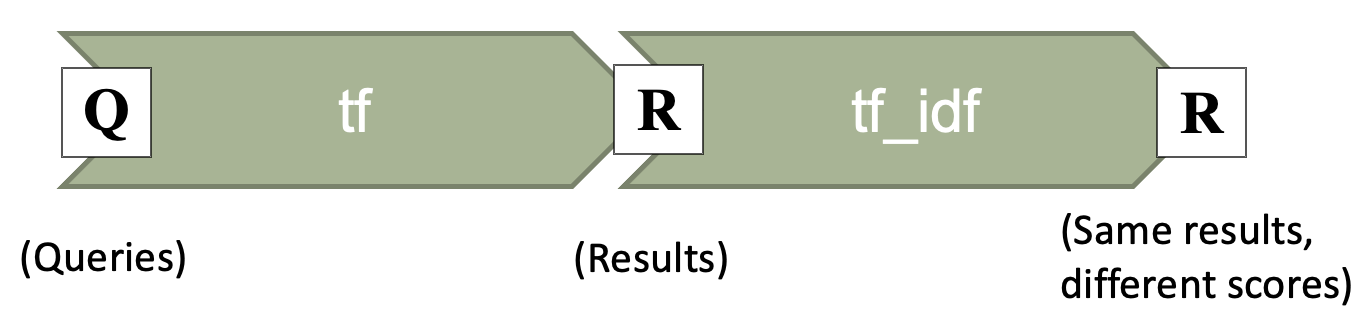

 The whole pipeline is also an instance of Transformer, so has the usual `.transform()`, `.search()` methods etc.:

In [118]:
pipeline.search("chemical reactions")

,qid,docid,docno,rank,score,query
0,1,9373,9374,0,12.088488,chemical reactions
1,1,8765,8766,1,11.225830,chemical reactions
2,1,7048,7049,2,11.038912,chemical reactions
3,1,4686,4687,3,10.582191,chemical reactions
4,1,10702,10703,4,7.381090,chemical reactions
5,1,2999,3000,5,7.050991,chemical reactions
6,1,5433,5434,6,7.050991,chemical reactions
7,1,1055,1056,7,6.857900,chemical reactions
8,1,2420,2421,8,6.778844,chemical reactions
9,1,3079,3080,9,6.747615,chemical reactions


There are a number of other PyTerrier operators:


| Operator | Meaning |
|----------|---------|
| `>>`     | Chaining together transformers, aka "Then" / composition|
| `+`	   |Linear combination of scores|
| `*`     |Scalar factoring of scores|
| `&` | Document Set Intersection |
| &#124; |Document Set Union |
| `%` |Apply rank cutoff |
| `^` | Concatenate the output of one transformer with another |
| **  | Feature Union |

Each of these operate on the dataframes returned by one or more transformers, and therefore has clear relational algebra semantics.  We provide worked examples of the input and output of each of the operators in the [PyTerrier documentation on operators](https://pyterrier.readthedocs.io/en/latest/operators.html). **Do take the time to browse this documenation - you will need to use operators in Task 4**.

Operators are a key concept of PyTerrier, and you will need to use operators to solve Task 4.

#### **Task 4**

In this task you will consider the use of the terrier.Retriever transformer for searching an index, and how to combine transformers together to make retrieval
pipelines. In particular, you will be experimenting with the PyTerrier *operators* when manipulating search results.

To improve your understanding of the PyTerrier operators, the task has two parts, asking you to deploy two specific rankers using the PyTerrier operators.


**(a)**

Create a ranker that returns the top 10 scored documents based on the following retrieval model:
$$
score(d,Q) = \big( \sum_{t \in Q} w_{TF\_IDF}(t,d) \big)  + 3 * \sum_{t \in Q} tf_{t,d}
$$
In essence, this equation scores documents by linearly combining the scores of two different retrieval models.

For the correct solution, your pipeline should return no more than 10 documents and document docno `"10703"` should have a score of 10.381090 for query `"chemical"`.

Hint: You do *not* need to access the inverted index directly.

**(b)**

Create a ranker that performs the following:

 - obtains the top 10 highest scoring documents by term frequency (wmodel="Tf")
 - obtains the top 10 highest scoring documents by TF.IDF (wmodel="TF_IDF")
 - reranks only those documents found in BOTH of the previous retrieval settings using the BM25 weighting model (Indeed BM25 is another famous weighting model that you will hear more about in Lecture 8).

How many documents are retrieved by this full pipeline for the query "chemical".

If you obtain the correct solution, the document with docno "2558" should have a score of 10.322110 for query "chemical".

Hints:
 - each correct solution needs only a few lines of code if you properly use the PyTerrier operators
 - you should not need to perform any Pandas dataframe operations
 - You will need to instantate a BM25 terrier.Retriever

In [137]:
tf = pt.terrier.Retriever(index, wmodel="Tf")
tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")

pipeline2 = 3*tf % 10
pipeline2.search("chemical")

,qid,docid,docno,rank,score,query
0,1,6278,6279,0,6.0,chemical
1,1,1055,1056,1,3.0,chemical
2,1,1139,1140,2,3.0,chemical
3,1,2049,2050,3,3.0,chemical
4,1,2416,2417,4,3.0,chemical
5,1,2519,2520,5,3.0,chemical
6,1,2557,2558,6,3.0,chemical
7,1,3319,3320,7,3.0,chemical
8,1,4053,4054,8,3.0,chemical
9,1,4686,4687,9,3.0,chemical


### What is Success?

So far, we have been creating search engine models, but we haven't decided if any of them is actually any good. While we will study *evaluation measures* in Lecture 5, let's just investigate if we are getting a correct ("relevant") document at the first rank.

In [ ]:
qrels = vaswani_dataset.get_qrels()
def get_res_with_labels(ranker, df):
  #get the results for the query or queries
  results = ranker( df )
  # left outer join with the qrels
  with_labels = results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)
  return with_labels

#lets get the Tf results for the first query
get_res_with_labels(tf, vaswani_dataset.get_topics().head(1) )



So, we got a relevant document third ranked using Tf. Let's check TF_IDF to see whether it does better:

In [ ]:
#lets get the tfidf results for the first query
get_res_with_labels(tfidf, vaswani_dataset.get_topics().head(1) )

Interesting - it got a relevant document at the top rank. Think about what TF_IDF is doing compared to Tf.

Keeping with the Tf ranking function, let's try to help it perform better by better formulating the query `'measurement of dielectric constant of liquids by the use of microwave techniques'`.

In particular, Terrier can take into account how often a query term occurs in a query. In doing so, documents are actually scored like this:
$$
score(d,Q) = \sum_{t \in Q} tf_{t,q} * tf_{t,d}
$$
where $tf_{t,d}$ is the frequency of the term in *document* and $tf_{t,q}$ is the frequency of the term in the *query*.

However, in our example query ( `'measurement of dielectric constant of liquids by the use of microwave techniques'`) all (non-stopword) query terms have a query term frequency of 1.

We can try to give more (or less) weight to some of these query terms, so as to place more or less emphasis on those terms, by appending a number such as `^2` (or `^0.1`) to some words in the query string. For example ^2 indicates that the weight of the corresponding term is 2.

In [ ]:
# here I try to change the emphasis on some words
newQueryDf = pd.DataFrame([
  ["1", "measurement^0.1 of dielectric constant of liquids by "+
    "the use of microwave techniques^2"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf )


#### **Task 5**

In this task, you will be familiarising yourself with an important aspect of users’ interaction with IR systems, namely how to reformulate queries in order to improve the effectiveness of the
system.

Spend **up to 5 minutes** trying to reformulate the above query by increasing or decreasing the weight of some query terms to get a relevant result at the first rank.

Hint: You might want to inspect some of the relevant (or non-relevant!) documents to see what words they contain. E.g. you might want to look at the contents of docnos 7923 and 3693.

In [ ]:
#YOUR SOLUTION

**Reflection**: While we could not manually reformulate each user's query, however knowing which words/terms should be important or not can help us understand what a good ranking model should do.

Later in the course, we'll talk about other approaches to (automatically) reformulate queries, such as query expansion, which can help to improve the search engine's effectiveness.


## That's all folks


Future IR exercises will build upon the learning outcome from this warmup lab. Should you need to reinforce any of the material in this lab, the following parts of the PyTerrier documentation will be useful:
 * [PyTerrier datasets](https://pyterrier.readthedocs.io/en/latest/datasets.html)
 * [Using Terrier for retrieval](https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html)
 * [Transformers in PyTerrier](https://pyterrier.readthedocs.io/en/latest/transformer.html)
 * [Transformer Operators](https://pyterrier.readthedocs.io/en/latest/operators.html)